# Percentile Ranking Single Asset Strategy

This notebook implements a percentile-based single asset selection strategy that:
- **Ranks each asset against its own historical performance distribution**
- **Selects the single asset with the highest percentile ranking**
- **Only invests when the best asset's percentile > 50%**
- **Otherwise holds cash**

This approach normalizes performance across assets with different volatility and return characteristics by comparing each asset to its own historical behavior.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from binance_data_loader import BinanceDataLoader
from tqdm import tqdm

In [2]:
# Load data
data_loader = BinanceDataLoader(
    data_directory=r"C:\Users\USER\Documents\Binance_related\dailytickerdata2020",
    min_records=30,
    min_volume=1e5,
    start_date="2023-01-01",
    end_date=None
)

Loading Binance data from C:\Users\USER\Documents\Binance_related\dailytickerdata2020...
Found 551 USDT trading pairs
✓ BTCUSDT loaded successfully with 1002 records, avg volume: 296,936
Loaded 514 cryptocurrencies
Filtered 35 cryptocurrencies (insufficient data/volume)
Precomputing returns matrix (FAST numpy version)...
Building returns matrix for 513 tickers over 1002 dates...
Precomputed returns matrix shape: (1002, 513)
Date range: 2023-01-01 00:00:00 to 2025-09-28 00:00:00


In [3]:
# Get price matrix
price = data_loader.get_price_matrix()
print(f"Price matrix shape: {price.shape}")
print(f"Date range: {price.index[0]} to {price.index[-1]}")

Price matrix shape: (1002, 513)
Date range: 2023-01-01 00:00:00 to 2025-09-28 00:00:00


In [4]:
# Strategy parameters - CUSTOMIZABLE
lookback_days = 14   # Lookback period for returns calculation
n_universe = 50      # Top N volume universe to select from each day
fees = 0.0005        # 5bps transaction fees per trade
percentile_threshold = 0.5  # Only invest if percentile > 50%

print(f"Strategy Parameters:")
print(f"  Lookback period: {lookback_days} days")
print(f"  Universe size: {n_universe}")
print(f"  Transaction fees: {fees*100:.2f} bps")
print(f"  Percentile threshold: {percentile_threshold*100:.0f}%")

Strategy Parameters:
  Lookback period: 14 days
  Universe size: 50
  Transaction fees: 0.05 bps
  Percentile threshold: 50%


In [5]:
# Prepare volume data for universe selection
volume_data = {}
for ticker in data_loader.get_universe():
    ticker_data = data_loader._crypto_universe[ticker]['data']
    volume_data[ticker] = ticker_data['volume'].reindex(price.index)

volume_matrix = pd.DataFrame(volume_data, index=price.index)
rolling_volume_matrix = volume_matrix.rolling(window=20, min_periods=10).mean()

print(f"Volume matrix shape: {volume_matrix.shape}")
print(f"Rolling volume matrix shape: {rolling_volume_matrix.shape}")

Volume matrix shape: (1002, 513)
Rolling volume matrix shape: (1002, 513)


In [6]:
# Calculate N-day returns for all assets
nday_returns = price.pct_change(lookback_days)

print(f"N-day returns shape: {nday_returns.shape}")
print(f"First valid return date: {nday_returns.dropna().index[0]}")

# Start from halfway through dataset to build sufficient percentile history
start_idx = len(price) // 2
print(f"Starting strategy from index {start_idx} ({price.index[start_idx]})")
print(f"This allows {start_idx} periods to build percentile history")

C:\Users\USER\AppData\Local\Temp\ipykernel_17456\3608040953.py:2: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  nday_returns = price.pct_change(lookback_days)


N-day returns shape: (1002, 513)
First valid return date: 2025-09-12 00:00:00
Starting strategy from index 501 (2024-05-16 00:00:00)
This allows 501 periods to build percentile history


In [7]:
# Initialize tracking variables
equity_percentile = [1.0]    # Strategy equity curve
percentiles_df = pd.DataFrame(index=price.index[start_idx:], columns=price.columns)  # Store percentiles
selected_assets = []         # Track which assets were selected
selected_percentiles = []    # Track the percentiles of selected assets
strategy_actions = []        # Track investment decisions

print(f"Running percentile ranking strategy...")
print(f"Processing {len(price) - start_idx - 1} periods")

for i in tqdm(range(start_idx, len(price) - 1)):
    current_date = price.index[i]
    
    # Get volume-filtered universe for this date
    current_volumes = rolling_volume_matrix.iloc[i].dropna()
    if len(current_volumes) == 0:
        equity_percentile.append(equity_percentile[-1])
        selected_assets.append(None)
        selected_percentiles.append(np.nan)
        strategy_actions.append('no_volume_data')
        continue
    
    # Select top N_universe by volume
    top_volume_tickers = current_volumes.nlargest(n_universe).index
    
    # Get historical returns up to current date for percentile calculation
    historical_returns = nday_returns.iloc[:i+1]  # All data up to current date
    
    # Calculate percentiles for each asset in the volume-filtered universe
    current_percentiles = []
    valid_assets = []
    
    for asset in top_volume_tickers:
        if asset in historical_returns.columns:
            # Get historical returns for this asset (drop NaN)
            asset_hist_returns = historical_returns[asset].dropna()
            
            if len(asset_hist_returns) > 10:  # Need sufficient history
                # Current return for this asset
                current_return = asset_hist_returns.iloc[-1]
                
                # Calculate percentile: what % of historical returns are <= current return
                if len(asset_hist_returns) > 1:
                    percentile = (asset_hist_returns <= current_return).sum() / (len(asset_hist_returns) - 1)
                else:
                    percentile = 0.5  # Default to median if insufficient data
                
                current_percentiles.append(percentile)
                valid_assets.append(asset)
                
                # Store percentile for analysis
                percentiles_df.loc[current_date, asset] = percentile
    
    if not current_percentiles:
        equity_percentile.append(equity_percentile[-1])
        selected_assets.append(None)
        selected_percentiles.append(np.nan)
        strategy_actions.append('no_valid_assets')
        continue
    
    # Find asset with highest percentile
    max_percentile_idx = np.argmax(current_percentiles)
    best_asset = valid_assets[max_percentile_idx]
    best_percentile = current_percentiles[max_percentile_idx]
    
    # Investment decision based on percentile threshold
    if best_percentile > percentile_threshold:
        # Invest in the best asset
        p0 = price[best_asset].iat[i]
        p1 = price[best_asset].iat[i+1]
        
        if np.isfinite(p0) and p0 != 0 and np.isfinite(p1):
            asset_return = (p1 - p0) / p0
            portfolio_return = asset_return - fees
            equity_percentile.append(equity_percentile[-1] * (1 + portfolio_return))
            strategy_actions.append('invested')
        else:
            equity_percentile.append(equity_percentile[-1])
            strategy_actions.append('price_error')
    else:
        # Hold cash - percentile not high enough
        equity_percentile.append(equity_percentile[-1])
        strategy_actions.append('cash')
    
    # Track selections
    selected_assets.append(best_asset)
    selected_percentiles.append(best_percentile)

print(f"\nBacktest completed!")
print(f"Final equity: {equity_percentile[-1]:.4f}")

Running percentile ranking strategy...
Processing 500 periods


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:21<00:00, 23.37it/s]


Backtest completed!
Final equity: 0.0515


In [8]:
# Create results DataFrame
results_dates = price.index[start_idx:start_idx + len(equity_percentile)]

results_df = pd.DataFrame({
    'equity': equity_percentile,
    'selected_asset': [None] + selected_assets,
    'selected_percentile': [np.nan] + selected_percentiles,
    'action': ['start'] + strategy_actions
}, index=results_dates)

# Strategy action statistics
print("=== STRATEGY ACTION STATISTICS ===")
action_counts = results_df['action'].value_counts()
for action, count in action_counts.items():
    pct = count / len(results_df) * 100
    print(f"  {action}: {count} days ({pct:.1f}%)")

# Asset selection statistics
print("\n=== MOST FREQUENTLY SELECTED ASSETS ===")
asset_counts = results_df['selected_asset'].value_counts().head(10)
for asset, count in asset_counts.items():
    if asset is not None:
        pct = count / len(results_df.dropna(subset=['selected_asset'])) * 100
        print(f"  {asset}: {count} times ({pct:.1f}%)")

# Percentile statistics
valid_percentiles = results_df['selected_percentile'].dropna()
print(f"\n=== SELECTED PERCENTILE STATISTICS ===")
print(f"  Mean percentile: {valid_percentiles.mean():.3f}")
print(f"  Median percentile: {valid_percentiles.median():.3f}")
print(f"  Min percentile: {valid_percentiles.min():.3f}")
print(f"  Max percentile: {valid_percentiles.max():.3f}")
print(f"  % above threshold ({percentile_threshold}): {(valid_percentiles > percentile_threshold).mean()*100:.1f}%")

=== STRATEGY ACTION STATISTICS ===
  invested: 495 days (98.8%)
  price_error: 3 days (0.6%)
  cash: 2 days (0.4%)
  start: 1 days (0.2%)

=== MOST FREQUENTLY SELECTED ASSETS ===
  TRXUSDT: 22 times (4.4%)
  DOODUSDT: 15 times (3.0%)
  MUBARAKUSDT: 14 times (2.8%)
  BANUSDT: 12 times (2.4%)
  COSUSDT: 11 times (2.2%)
  MEMEFIUSDT: 11 times (2.2%)
  1MBABYDOGEUSDT: 11 times (2.2%)
  VINEUSDT: 10 times (2.0%)
  PUMPUSDT: 10 times (2.0%)
  STMXUSDT: 10 times (2.0%)

=== SELECTED PERCENTILE STATISTICS ===
  Mean percentile: 0.989
  Median percentile: 1.000
  Min percentile: 0.405
  Max percentile: 1.100
  % above threshold (0.5): 99.6%


In [9]:
# Performance metrics
def calculate_performance_metrics(equity_series, strategy_name):
    total_return = (equity_series.iloc[-1] - 1) * 100
    daily_returns = equity_series.pct_change().dropna()
    
    ann_return = daily_returns.mean() * 252 * 100
    ann_vol = daily_returns.std() * np.sqrt(252) * 100
    sharpe = daily_returns.mean() / daily_returns.std() * np.sqrt(252) if daily_returns.std() > 0 else 0
    max_dd = (equity_series / equity_series.cummax() - 1).min() * 100
    
    win_rate = (daily_returns > 0).mean() * 100
    
    print(f"\n=== {strategy_name.upper()} PERFORMANCE ===")
    print(f"Total Return: {total_return:.2f}%")
    print(f"Annualized Return: {ann_return:.2f}%")
    print(f"Annualized Volatility: {ann_vol:.2f}%")
    print(f"Sharpe Ratio: {sharpe:.3f}")
    print(f"Maximum Drawdown: {max_dd:.2f}%")
    print(f"Win Rate: {win_rate:.1f}%")
    
    return {
        'total_return': total_return,
        'ann_return': ann_return,
        'ann_vol': ann_vol,
        'sharpe': sharpe,
        'max_dd': max_dd,
        'win_rate': win_rate
    }

# Calculate performance
equity_series = pd.Series(equity_percentile, index=results_dates)
strategy_perf = calculate_performance_metrics(equity_series, "Percentile Ranking Strategy")

# BTC comparison
btc_cumret = (1 + price["BTCUSDT"].pct_change().fillna(0)).cumprod()
btc_aligned = btc_cumret.reindex(results_dates)
btc_perf = calculate_performance_metrics(btc_aligned, "BTC Buy & Hold")


=== PERCENTILE RANKING STRATEGY PERFORMANCE ===
Total Return: -94.85%
Annualized Return: 59.36%
Annualized Volatility: 225.70%
Sharpe Ratio: 0.263
Maximum Drawdown: -99.41%
Win Rate: 40.6%

=== BTC BUY & HOLD PERFORMANCE ===
Total Return: 560.99%
Annualized Return: 33.27%
Annualized Volatility: 37.63%
Sharpe Ratio: 0.884
Maximum Drawdown: -28.10%
Win Rate: 51.0%


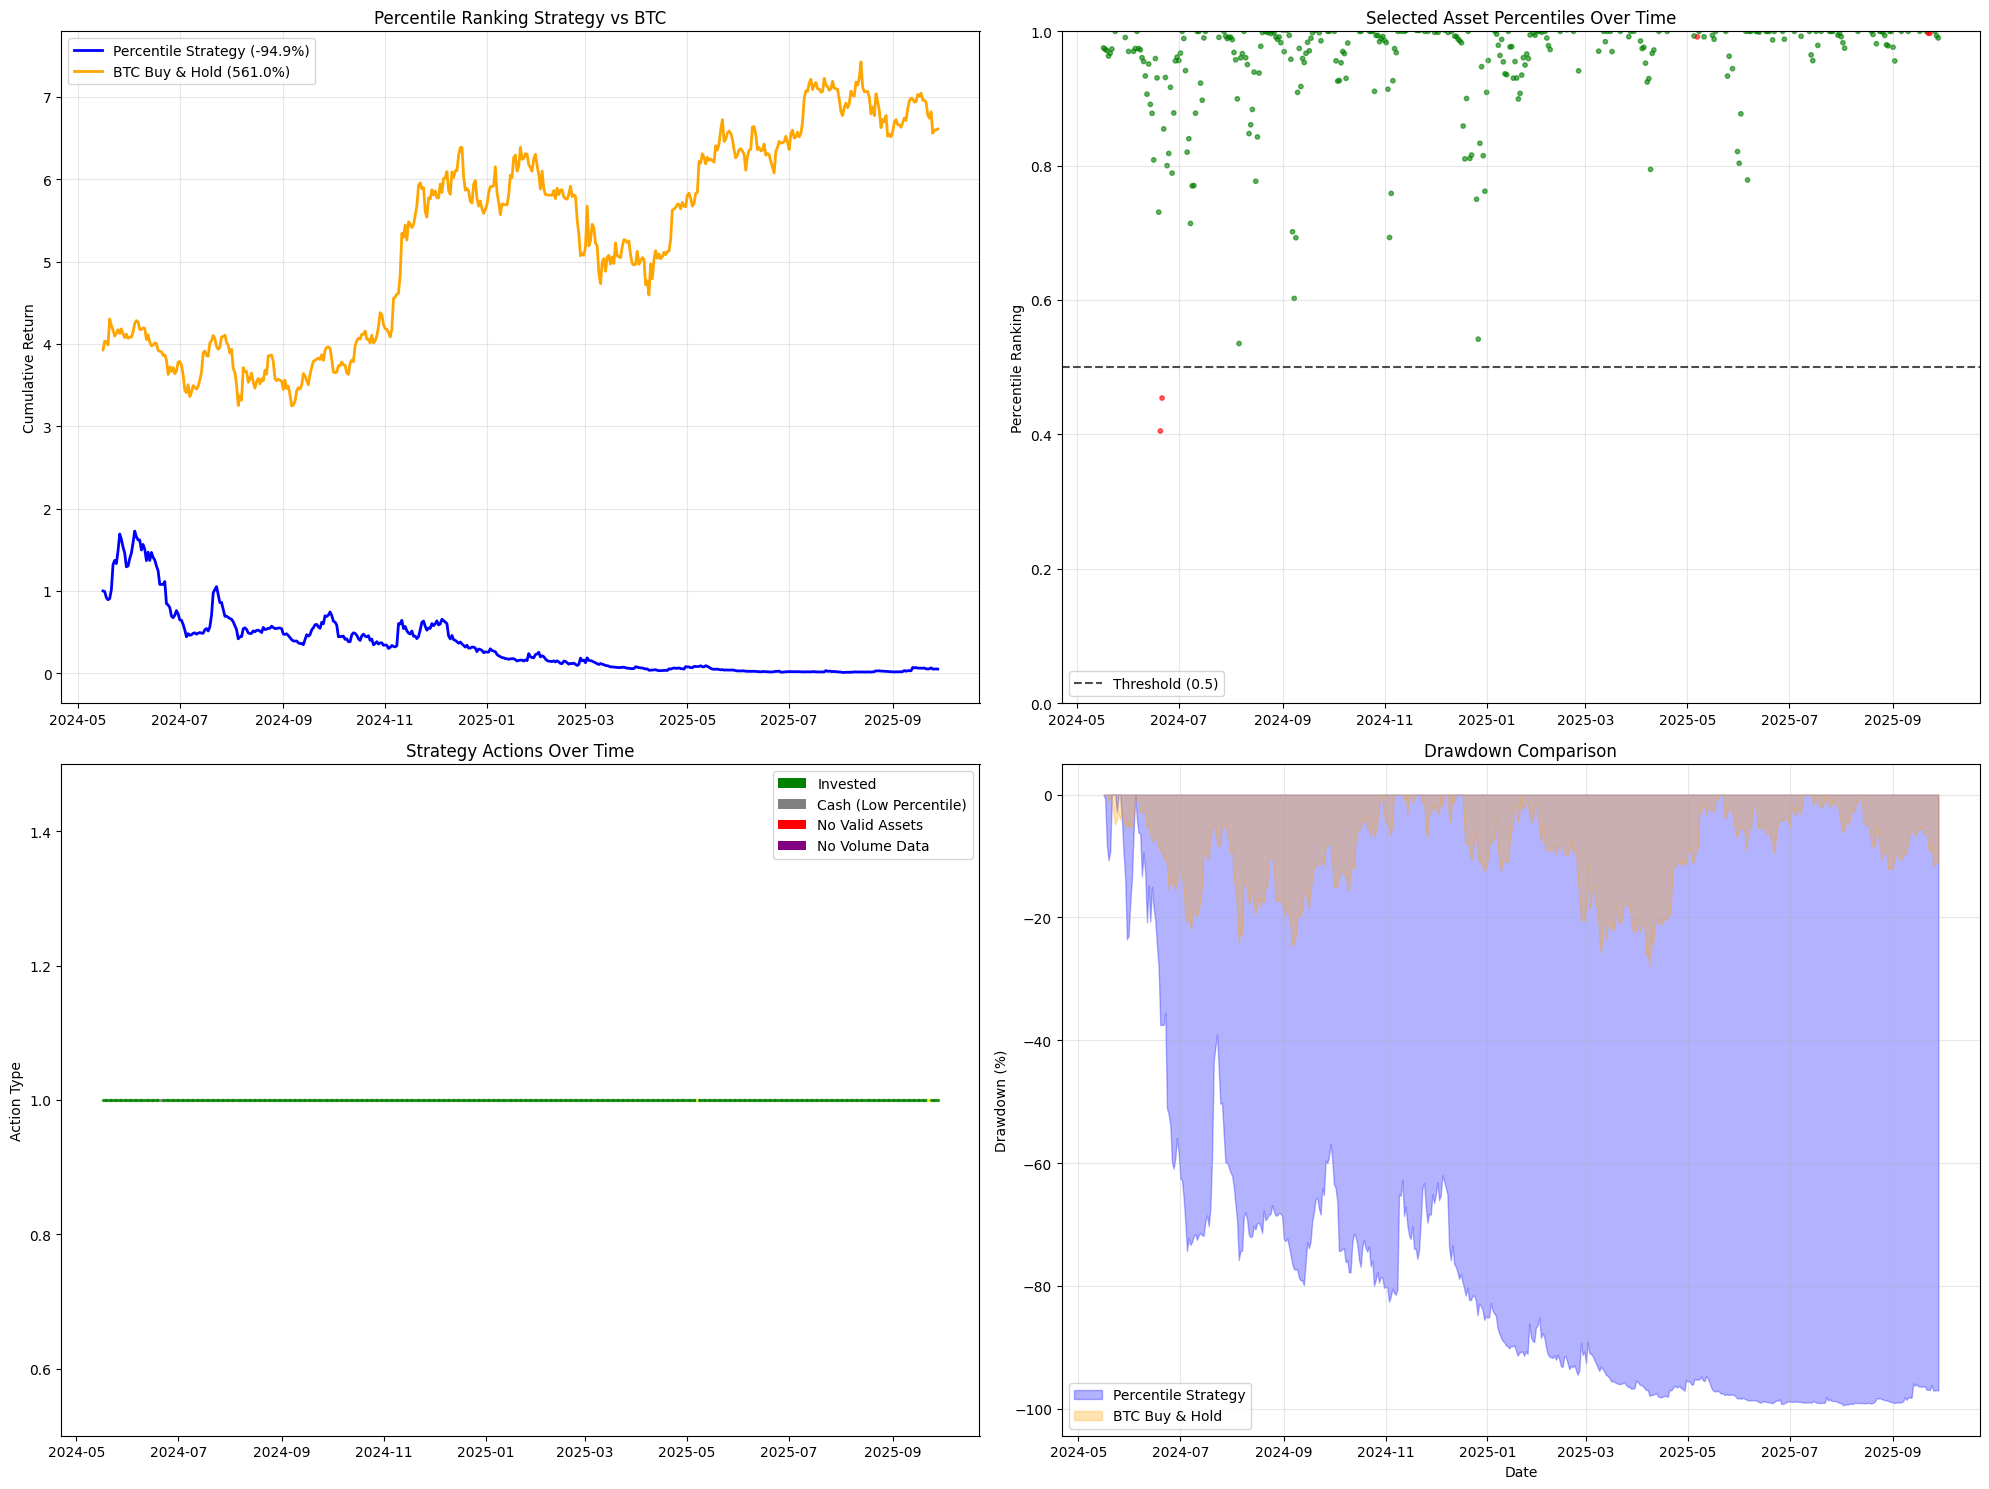

In [10]:
# Visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 15))

# Equity curve comparison
ax1.plot(equity_series.index, equity_series, 
         label=f'Percentile Strategy ({strategy_perf["total_return"]:.1f}%)', linewidth=2, color='blue')
ax1.plot(btc_aligned.index, btc_aligned, 
         label=f'BTC Buy & Hold ({btc_perf["total_return"]:.1f}%)', linewidth=2, color='orange')
ax1.set_title('Percentile Ranking Strategy vs BTC')
ax1.set_ylabel('Cumulative Return')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Selected percentiles over time
valid_results = results_df.dropna(subset=['selected_percentile'])
ax2.scatter(valid_results.index, valid_results['selected_percentile'], 
           c=['green' if action == 'invested' else 'red' for action in valid_results['action']], 
           alpha=0.6, s=10)
ax2.axhline(y=percentile_threshold, color='black', linestyle='--', alpha=0.7, 
           label=f'Threshold ({percentile_threshold})')
ax2.set_title('Selected Asset Percentiles Over Time')
ax2.set_ylabel('Percentile Ranking')
ax2.set_ylim(0, 1)
ax2.legend()
ax2.grid(True, alpha=0.3)

# Strategy actions over time
action_colors = {'invested': 'green', 'cash': 'gray', 'start': 'black', 
                'no_volume_data': 'purple', 'no_valid_assets': 'red', 'price_error': 'yellow'}

for i, (date, action) in enumerate(zip(results_df.index, results_df['action'])):
    if i > 0:  # Skip first point
        ax3.scatter(date, 1, c=action_colors.get(action, 'black'), alpha=0.7, s=2)

ax3.set_title('Strategy Actions Over Time')
ax3.set_ylabel('Action Type')
ax3.set_ylim(0.5, 1.5)

# Add legend for action colors
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='green', label='Invested'),
    Patch(facecolor='gray', label='Cash (Low Percentile)'),
    Patch(facecolor='red', label='No Valid Assets'),
    Patch(facecolor='purple', label='No Volume Data')
]
ax3.legend(handles=legend_elements)

# Drawdown comparison
strategy_dd = (equity_series / equity_series.cummax() - 1) * 100
btc_dd = (btc_aligned / btc_aligned.cummax() - 1) * 100

ax4.fill_between(strategy_dd.index, strategy_dd, 0, alpha=0.3, color='blue', label='Percentile Strategy')
ax4.fill_between(btc_dd.index, btc_dd, 0, alpha=0.3, color='orange', label='BTC Buy & Hold')
ax4.set_title('Drawdown Comparison')
ax4.set_ylabel('Drawdown (%)')
ax4.set_xlabel('Date')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [11]:
# Performance comparison table
comparison_df = pd.DataFrame({
    'Percentile Strategy': [strategy_perf['total_return'], strategy_perf['ann_return'], 
                           strategy_perf['ann_vol'], strategy_perf['sharpe'], 
                           strategy_perf['max_dd'], strategy_perf['win_rate']],
    'BTC Buy & Hold': [btc_perf['total_return'], btc_perf['ann_return'], 
                      btc_perf['ann_vol'], btc_perf['sharpe'], 
                      btc_perf['max_dd'], btc_perf['win_rate']]
}, index=['Total Return (%)', 'Ann. Return (%)', 'Ann. Volatility (%)', 
          'Sharpe Ratio', 'Max Drawdown (%)', 'Win Rate (%)'])

print("\n" + "="*60)
print("PERFORMANCE COMPARISON TABLE")
print("="*60)
print(comparison_df.round(2))


PERFORMANCE COMPARISON TABLE
                     Percentile Strategy  BTC Buy & Hold
Total Return (%)                  -94.85          560.99
Ann. Return (%)                    59.36           33.27
Ann. Volatility (%)               225.70           37.63
Sharpe Ratio                        0.26            0.88
Max Drawdown (%)                  -99.41          -28.10
Win Rate (%)                       40.60           51.00


In [12]:
# Asset selection analysis
print(f"\n" + "="*60)
print("ASSET SELECTION ANALYSIS")
print("="*60)

# Concentration analysis
invested_results = results_df[results_df['action'] == 'invested']
if len(invested_results) > 0:
    unique_assets_selected = invested_results['selected_asset'].nunique()
    total_investments = len(invested_results)
    
    print(f"\nSelection Concentration:")
    print(f"  Total investment periods: {total_investments}")
    print(f"  Unique assets selected: {unique_assets_selected}")
    print(f"  Average selections per asset: {total_investments/unique_assets_selected:.1f}")
    
    # Top 5 most selected assets with their average percentiles
    print(f"\nTop 5 Most Selected Assets:")
    top_assets = invested_results['selected_asset'].value_counts().head(5)
    for asset, count in top_assets.items():
        avg_percentile = invested_results[invested_results['selected_asset'] == asset]['selected_percentile'].mean()
        print(f"  {asset}: {count} times (avg percentile: {avg_percentile:.3f})")
    
    # Percentile distribution of investments
    print(f"\nPercentile Distribution of Actual Investments:")
    investment_percentiles = invested_results['selected_percentile']
    print(f"  Mean: {investment_percentiles.mean():.3f}")
    print(f"  25th percentile: {investment_percentiles.quantile(0.25):.3f}")
    print(f"  50th percentile: {investment_percentiles.quantile(0.50):.3f}")
    print(f"  75th percentile: {investment_percentiles.quantile(0.75):.3f}")
    print(f"  95th percentile: {investment_percentiles.quantile(0.95):.3f}")
else:
    print("No investment periods found!")


ASSET SELECTION ANALYSIS

Selection Concentration:
  Total investment periods: 495
  Unique assets selected: 102
  Average selections per asset: 4.9

Top 5 Most Selected Assets:
  TRXUSDT: 20 times (avg percentile: 0.969)
  DOODUSDT: 15 times (avg percentile: 1.029)
  MUBARAKUSDT: 14 times (avg percentile: 1.047)
  BANUSDT: 12 times (avg percentile: 0.951)
  MEMEFIUSDT: 11 times (avg percentile: 1.007)

Percentile Distribution of Actual Investments:
  Mean: 0.992
  25th percentile: 0.973
  50th percentile: 1.000
  75th percentile: 1.034
  95th percentile: 1.091


In [13]:
# Strategy insights and parameter sensitivity
print(f"\n" + "="*60)
print("STRATEGY INSIGHTS")
print("="*60)

print(f"\nStrategy Parameters Used:")
print(f"  Lookback period: {lookback_days} days")
print(f"  Universe size: {n_universe}")
print(f"  Percentile threshold: {percentile_threshold}")
print(f"  Transaction fees: {fees*100:.2f} bps")

# Calculate investment frequency
investment_rate = (results_df['action'] == 'invested').mean() * 100
cash_rate = (results_df['action'] == 'cash').mean() * 100

print(f"\nStrategy Behavior:")
print(f"  Investment rate: {investment_rate:.1f}%")
print(f"  Cash holding rate: {cash_rate:.1f}%")

if strategy_perf['sharpe'] > btc_perf['sharpe']:
    print(f"  ✓ Strategy outperforms BTC on risk-adjusted basis (Sharpe: {strategy_perf['sharpe']:.3f} vs {btc_perf['sharpe']:.3f})")
else:
    print(f"  ✗ BTC outperforms strategy on risk-adjusted basis (Sharpe: {btc_perf['sharpe']:.3f} vs {strategy_perf['sharpe']:.3f})")

if abs(strategy_perf['max_dd']) < abs(btc_perf['max_dd']):
    print(f"  ✓ Strategy has lower maximum drawdown ({abs(strategy_perf['max_dd']):.1f}% vs {abs(btc_perf['max_dd']):.1f}%)")
else:
    print(f"  ✗ BTC has lower maximum drawdown ({abs(btc_perf['max_dd']):.1f}% vs {abs(strategy_perf['max_dd']):.1f}%)")

print(f"\nParameter Sensitivity Notes:")
print(f"  • Lower percentile_threshold → More frequent trading, higher turnover")
print(f"  • Higher percentile_threshold → More selective, potentially missing opportunities")
print(f"  • Shorter lookback_days → More responsive to recent moves, higher turnover")
print(f"  • Larger n_universe → More assets to choose from, better diversification opportunities")
print(f"  • Current threshold ({percentile_threshold}) results in {investment_rate:.1f}% investment rate")


STRATEGY INSIGHTS

Strategy Parameters Used:
  Lookback period: 14 days
  Universe size: 50
  Percentile threshold: 0.5
  Transaction fees: 0.05 bps

Strategy Behavior:
  Investment rate: 98.8%
  Cash holding rate: 0.4%
  ✗ BTC outperforms strategy on risk-adjusted basis (Sharpe: 0.884 vs 0.263)
  ✗ BTC has lower maximum drawdown (28.1% vs 99.4%)

Parameter Sensitivity Notes:
  • Lower percentile_threshold → More frequent trading, higher turnover
  • Higher percentile_threshold → More selective, potentially missing opportunities
  • Shorter lookback_days → More responsive to recent moves, higher turnover
  • Larger n_universe → More assets to choose from, better diversification opportunities
  • Current threshold (0.5) results in 98.8% investment rate



PERCENTILE DISTRIBUTION ANALYSIS

Overall Percentile Statistics (all assets, all dates):
  Total observations: 23,753
  Mean percentile: 0.521
  Std percentile: 0.311
  % above threshold: 52.7%

Percentile Distribution:
   10th percentile: 0.084
   25th percentile: 0.239
   50th percentile: 0.535
   75th percentile: 0.794
   90th percentile: 0.943
   95th percentile: 0.985
   99th percentile: 1.019


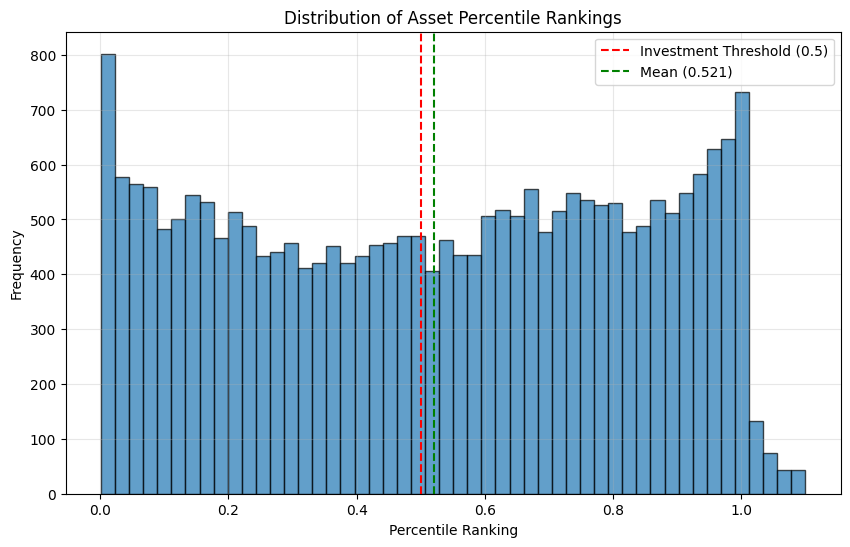

In [14]:
# Historical percentile analysis (optional deep dive)
print(f"\n" + "="*60)
print("PERCENTILE DISTRIBUTION ANALYSIS")
print("="*60)

# Analyze the distribution of percentiles across all assets and dates
all_percentiles = percentiles_df.stack().dropna()

if len(all_percentiles) > 0:
    print(f"\nOverall Percentile Statistics (all assets, all dates):")
    print(f"  Total observations: {len(all_percentiles):,}")
    print(f"  Mean percentile: {all_percentiles.mean():.3f}")
    print(f"  Std percentile: {all_percentiles.std():.3f}")
    print(f"  % above threshold: {(all_percentiles > percentile_threshold).mean()*100:.1f}%")
    
    # Show percentile distribution
    print(f"\nPercentile Distribution:")
    for p in [0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]:
        value = all_percentiles.quantile(p)
        print(f"  {p*100:3.0f}th percentile: {value:.3f}")
        
    # Create a simple histogram
    plt.figure(figsize=(10, 6))
    plt.hist(all_percentiles, bins=50, alpha=0.7, edgecolor='black')
    plt.axvline(x=percentile_threshold, color='red', linestyle='--', 
                label=f'Investment Threshold ({percentile_threshold})')
    plt.axvline(x=all_percentiles.mean(), color='green', linestyle='--', 
                label=f'Mean ({all_percentiles.mean():.3f})')
    plt.xlabel('Percentile Ranking')
    plt.ylabel('Frequency')
    plt.title('Distribution of Asset Percentile Rankings')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("No percentile data available for analysis.")